# Setup

In [1]:
import pandas as pd
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['#118AB2', '#b13e2b', '#39b26c', '#dfdf07', '#852293'])

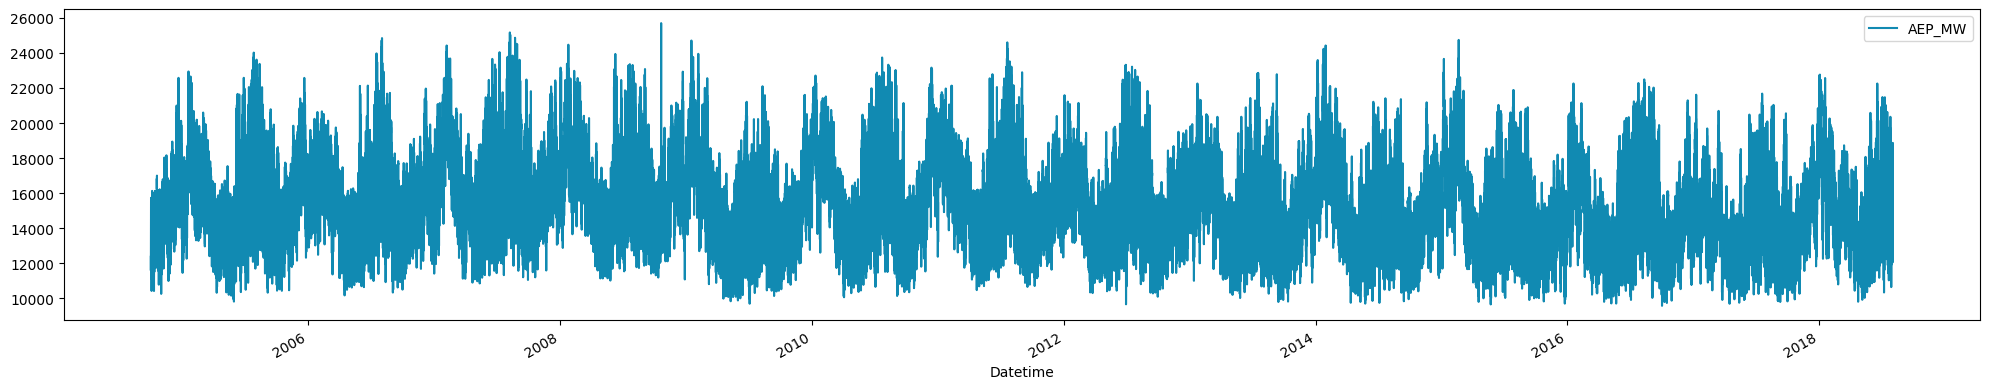

In [2]:
df = pd.read_csv("data/AEP_hourly.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(20,4))
df.plot(ax=ax)
plt.tight_layout()
plt.show()

### Visual Inspection

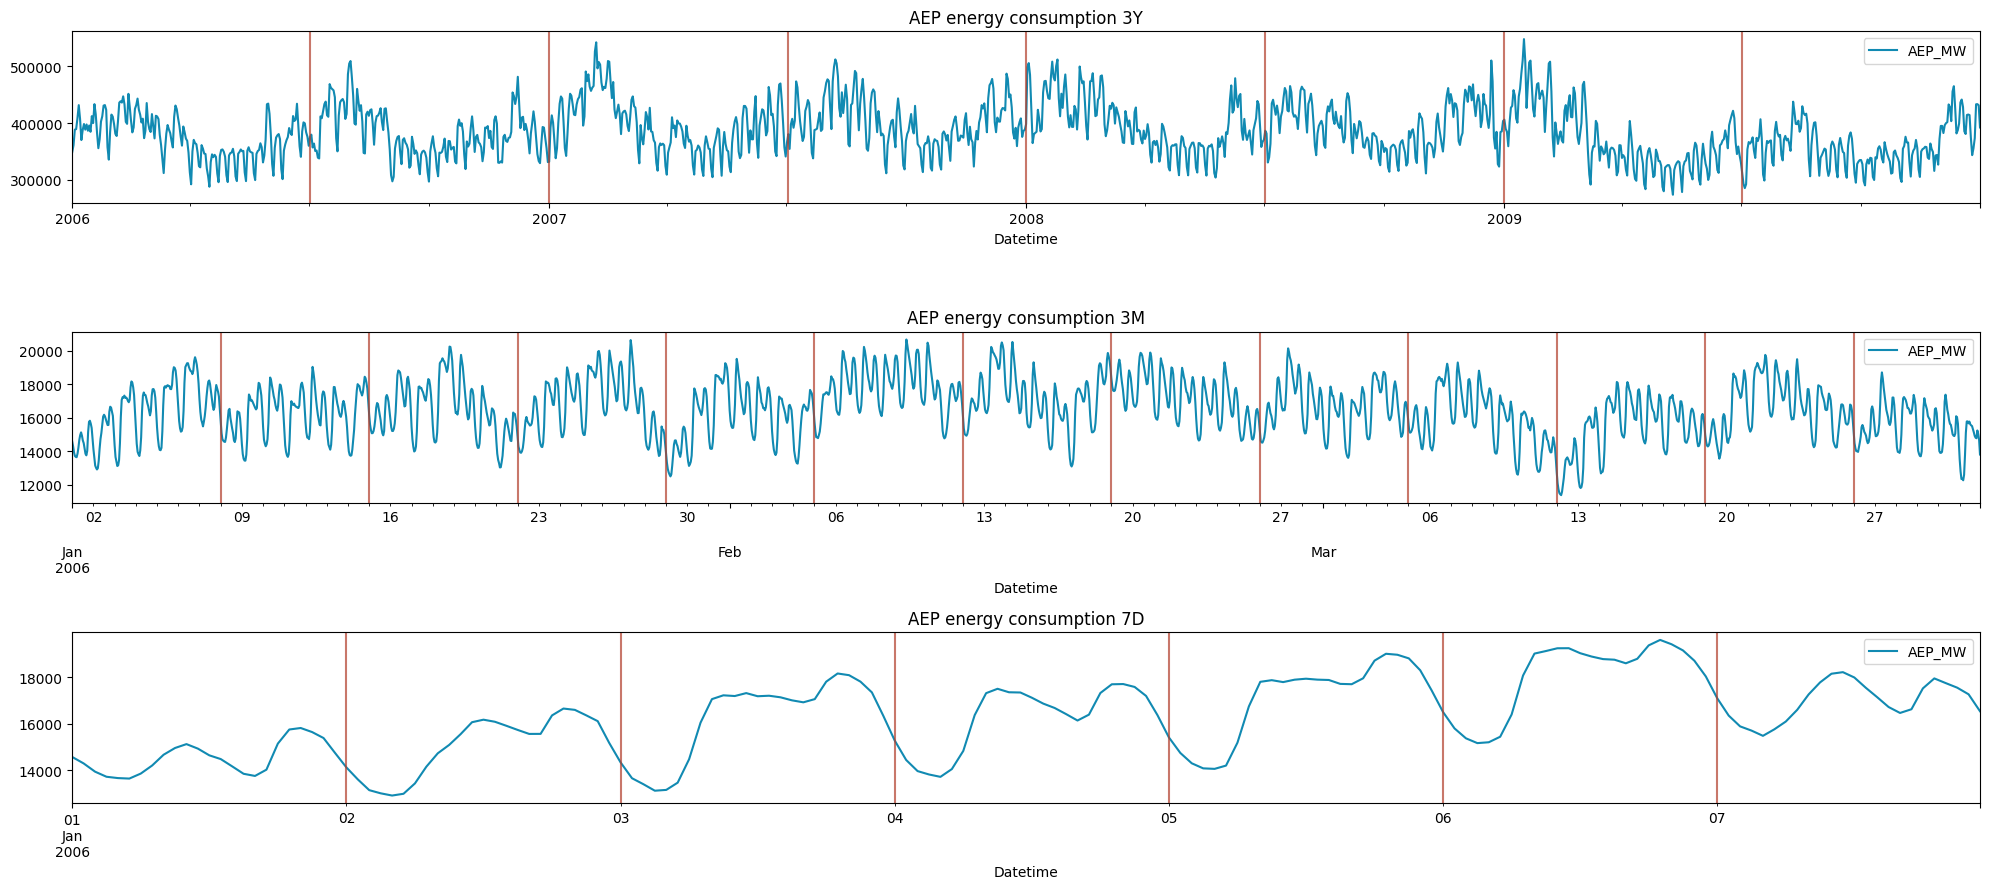

In [3]:

fig, ax = plt.subplots(3, 1, figsize=(20,9))

df_3y = df[(df.index >= '2006-01-01') & (df.index < '2010-01-01')]
df_3M = df[(df.index >= '2006-01-01') & (df.index < '2006-04-01')]
df_7d = df[(df.index >= '2006-01-01') & (df.index < '2006-01-08')]

ax[0].set_title('AEP energy consumption 3Y')
df_3y[['AEP_MW']].groupby(pd.Grouper(freq = 'D')).sum().plot(ax=ax[0])
for date in df_3y[[True if x % (24 * 365.25 / 2) == 0 else False for x in range(len(df_3y))]].index.tolist():
    ax[0].axvline(date, color = '#b13e2b', alpha = 0.7)
    
ax[1].set_title('AEP energy consumption 3M')
df_3M[['AEP_MW']].plot(ax=ax[1])
for date in df_3M[[True if x % (24 * 7) == 0 else False for x in range(len(df_3M))]].index.tolist():
    ax[1].axvline(date, color = '#b13e2b', alpha = 0.7)
                                                                            
ax[2].set_title('AEP energy consumption 7D')
df_7d[['AEP_MW']].plot(ax=ax[2])
for date in df_7d[[True if x % 24 == 0 else False for x in range(len(df_7d))]].index.tolist():
    ax[2].axvline(date, color = '#b13e2b', alpha = 0.7)

plt.tight_layout()
plt.show()

### FFT

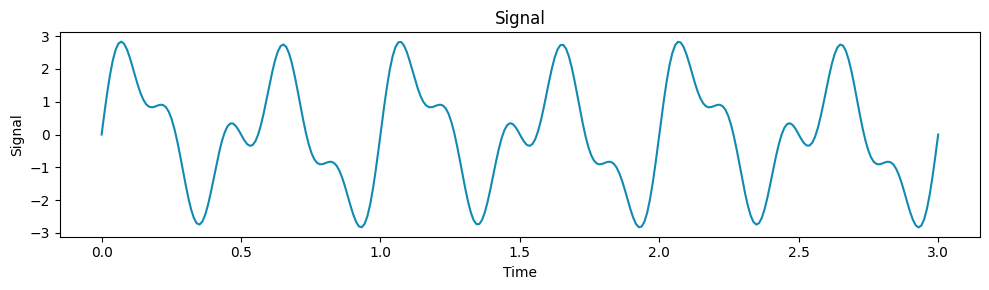

In [4]:
t = np.linspace(0, 3, 3 * 100)
signal = 2 * np.sin(2*np.pi * 2 * t) + 0.5 * np.sin(2*np.pi * 3 * t) + np.sin(2*np.pi * 5 * t)

_, ax = plt.subplots(figsize=(10,3))
ax.plot(t, signal)
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.tight_layout()
plt.show()

[]

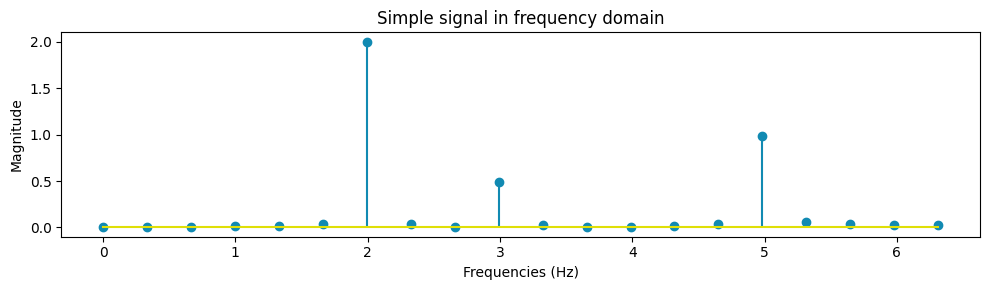

In [5]:
frequencies = np.fft.fftfreq(len(t),  t[1] - t[0])   # Frequency axis
fft_magnitude = np.abs(np.fft.fft(signal)) / (len(t)/2)  # Normalized FFT output

mask = frequencies >= 0 
frequencies = frequencies[mask]
fft_magnitude = fft_magnitude[mask]

_, ax = plt.subplots(figsize=(10,3))
ax.stem(frequencies[:20],fft_magnitude[:20])
ax.set_xlabel('Frequencies (Hz)') 
ax.set_title('Discrete Fourier Transform')
plt.title('Simple signal in frequency domain')
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.plot()

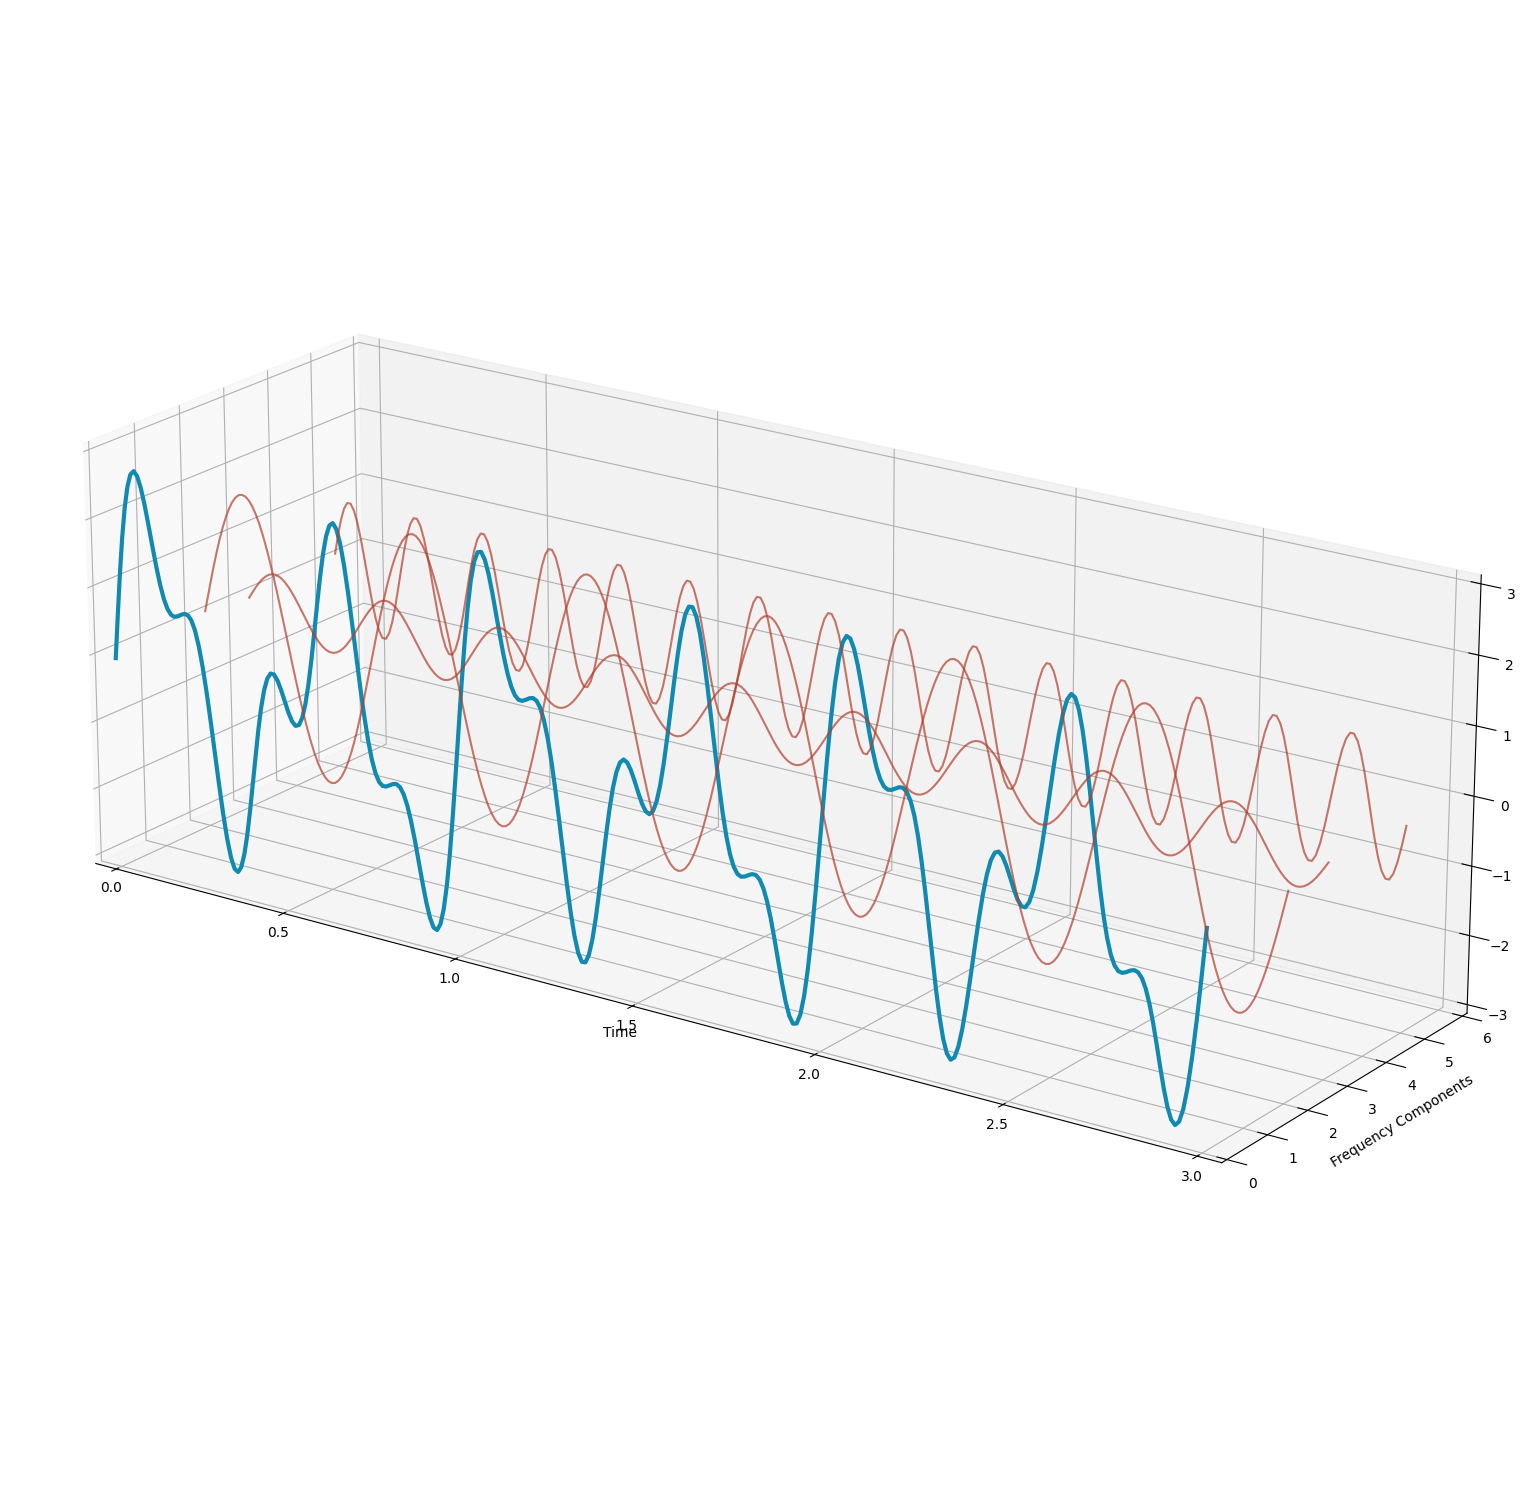

In [6]:
# Time domain
t = np.linspace(0, 3, 3 * 100)
signal = 2 * np.sin(2*np.pi * 2 * t) + 0.5 * np.sin(2*np.pi * 3 * t) + np.sin(2*np.pi * 5 * t)

# Compute FFT
N = len(t)
frequencies = np.fft.fftfreq(N, d=(t[1] - t[0]))
fft_coeffs = np.fft.fft(signal)  
num_components = 3  
z_levels = [2,3,5]  

# Create 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t, signal, zs=0, zdir='y', color='#118AB2', linewidth=3, label="Original Signal")
for i, z in enumerate([6, 9, 15]): 
    amp = np.abs(fft_coeffs[z]) / (N/2)  # Amplitude scaling
    phase = np.angle(fft_coeffs[z])  # Phase shift
    component = amp * np.cos(2 * np.pi * frequencies[z] * t + phase)  # Reconstruct wave
    ax.plot(t, component, zs=z_levels[i], zdir='y', alpha=0.7, color = '#b13e2b')

# Customize view
ax.set_xlabel('Time')
ax.set_ylabel('Frequency Components')
ax.set_zlabel('Amplitude')
ax.view_init(elev=20, azim=-55) 
ax.set_box_aspect([3, 1, 1])  
ax.set_xlim([0, 3])  
ax.set_ylim([0,6])
ax.set_zlim([-3, 3]) 
plt.tight_layout()
plt.show()


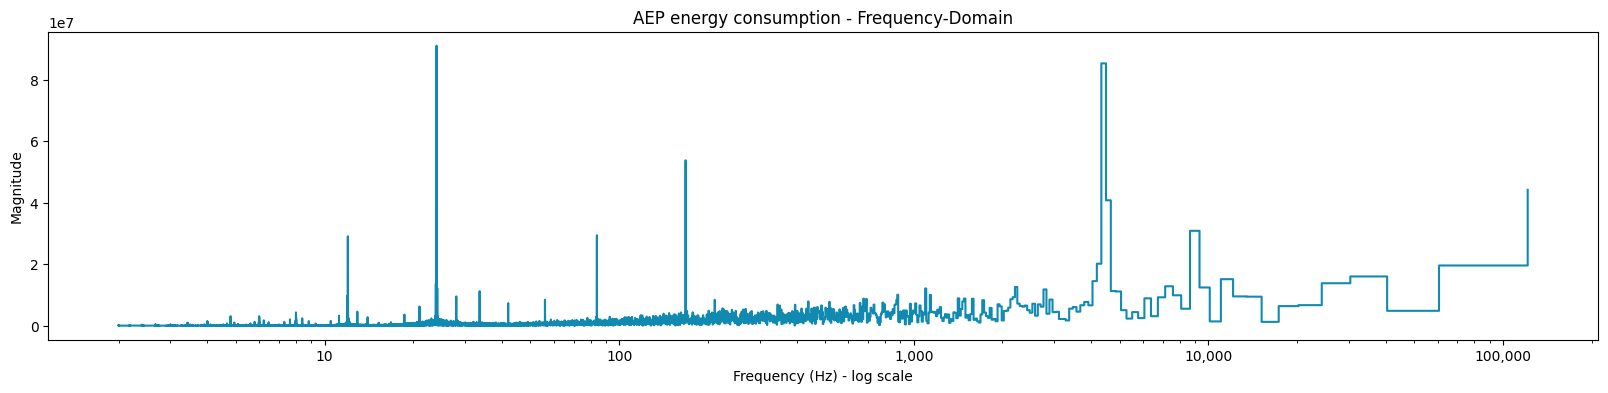

In [7]:
# Perform Fourier Transform
X = fft.fft(df['AEP_MW'])
N = len(df)
frequencies = fft.fftfreq(N, 1)
with np.errstate(divide='ignore'):
    periods = 1 / frequencies
mask = frequencies >= 0 

# Plot the Fourier Transform
fig, ax = plt.subplots(figsize=(20, 4))
ax.step(periods[mask], np.abs(X)[mask])  # Only plot positive frequencies
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.set_title('AEP energy consumption - Frequency-Domain')
ax.set_xlabel('Frequency (Hz) - log scale')
ax.set_ylabel('Magnitude')
plt.show()


### Periodogram

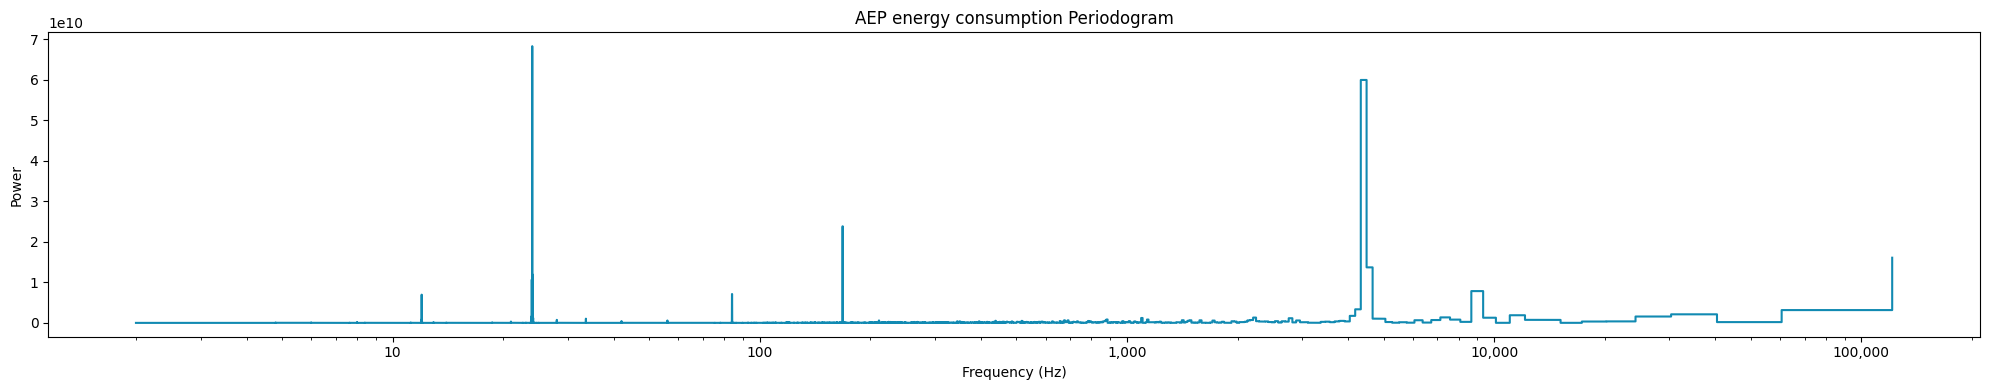

In [8]:
power_manual = np.abs(X)**2 / N  # Power at each frequency
fig, ax = plt.subplots(figsize=(20, 4))
ax.step(periods[mask], power_manual[mask])
ax.set_title('AEP energy consumption Periodogram')
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

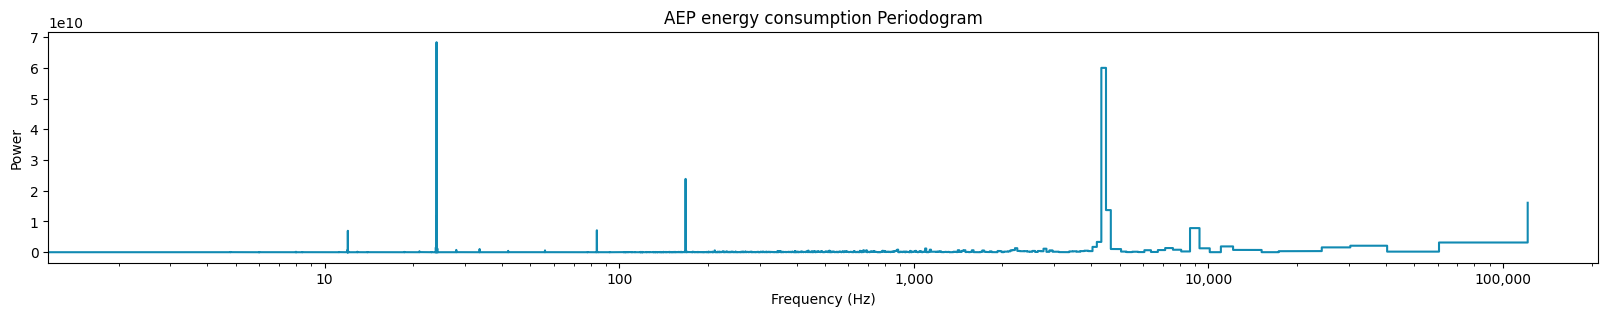

In [9]:
frequencies, power_spectrum = periodogram(df['AEP_MW'], return_onesided=False)
with np.errstate(divide='ignore'):
    periods = 1 / frequencies

fig, ax = plt.subplots(figsize=(20, 3))
ax.step(periods, power_spectrum)
ax.set_title('AEP energy consumption Periodogram')
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()